In [1]:

# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

     |████████████████████████████████| 1.7 MB 93 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=5e28de055fcc2d26fd0930981e4047e7b7e788055e1e0985017f85dc13d600c3
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
from google.colab import files
uploaded = files.upload()
import io
RowTweetdata = pd.read_csv(io.BytesIO(uploaded["CleanDataAva00.csv"]))
Tweetdata = RowTweetdata
Tweetdata

Saving CleanDataAva00.csv to CleanDataAva00.csv


,ID,RawText,CleanText
0,0,RT @kingstarleo1: #Healthcare #Blockchain #Sup...,kingstarleo healthcar blockchain supplychain p...
1,1,#Healthcare #Blockchain #Supplychain #Procurem...,healthcar blockchain supplychain procur logist...
2,2,"RT @NEARhealth_: It all start with education, ...",nearhealth it start educ join u explor web hea...
3,3,"RT @NEARhealth_: It all start with education, ...",nearhealth it start educ join u explor web hea...
4,4,"RT @NEARhealth_: It all start with education, ...",nearhealth it start educ join u explor web hea...
...,...,...,...
2093,2093,RT @Kiwi_Lemon_: To know more &amp; discuss Ki...,kiwi lemon to know amp discus kiwilemon join t...
2094,2094,@medifakt I hope this project is a success and...,medifakt i hope project success becom one best...
2095,2095,RT @Devitaglobal: #DEVITA has been designed as...,devitaglob devita design health platform base ...
2096,2096,RT @Devitaglobal: #DEVITA has been designed as...,devitaglob devita design health platform base ...


In [5]:
data = Tweetdata

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data['CleanText']))

print(data_words[:])

[['kingstarleo', 'healthcar', 'blockchain', 'supplychain', 'procur', 'logist', 'improv', 'qualiti', 'care', 'reduc', 'cost', 'increas', 'access', 'the'], ['healthcar', 'blockchain', 'supplychain', 'procur', 'logist', 'improv', 'qualiti', 'care', 'reduc', 'cost', 'increas', 'access', 'the', 'time', 'tomorrow', 'built', 'today', 'get', 'engag', 'get', 'invest', 'join', 'discus', 'listen', 'learn', 'leverag', 'way', 'reverdefi'], ['nearhealth', 'it', 'start', 'educ', 'join', 'explor', 'web', 'healthcar', 'industri', 'topic', 'healthtech', 'app'], ['nearhealth', 'it', 'start', 'educ', 'join', 'explor', 'web', 'healthcar', 'industri', 'topic', 'healthtech', 'app'], ['nearhealth', 'it', 'start', 'educ', 'join', 'explor', 'web', 'healthcar', 'industri', 'topic', 'healthtech', 'app'], ['nearhealth', 'it', 'start', 'educ', 'join', 'explor', 'web', 'healthcar', 'industri', 'topic', 'healthtech', 'app'], ['it', 'start', 'educ', 'join', 'explor', 'web', 'healthcar', 'industri', 'topic', 'healthtec

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['kingstarleo', 'healthcar', 'blockchain', 'supplychain', 'procur', 'logist', 'improv', 'qualiti', 'care', 'reduc', 'cost', 'increas', 'access', 'the']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['care', 'cost', 'increa', 'access']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [11]:
id2word[5]

'get'

In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('access', 1), ('care', 1), ('cost', 1), ('increa', 1)]]

In [13]:
# Build LDA model
Num_Topics = 3
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= Num_Topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"platform" + 0.046*"cloudcomput" + 0.042*"first" + 0.036*"healthcar" '
  '+ 0.032*"check" + 0.029*"token" + 0.019*"lead" + 0.018*"cardano" + '
  '0.015*"invest" + 0.014*"gener"'),
 (1,
  '0.045*"healthcar" + 0.045*"blockchain" + 0.040*"system" + 0.037*"access" + '
  '0.034*"record" + 0.027*"metaver" + 0.027*"health" + 0.022*"make" + '
  '0.020*"project" + 0.018*"come"'),
 (2,
  '0.164*"co" + 0.045*"blockchain" + 0.038*"patient" + 0.036*"healthcar" + '
  '0.034*"datum" + 0.034*"ai" + 0.030*"http" + 0.027*"covid" + 0.024*"work" + '
  '0.022*"program"')]


In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.832664544894953

Coherence Score:  0.47553052854973377


In [16]:
!pip install datascience
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install tensorflow

     |████████████████████████████████| 69 kB 3.4 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=7a0c1eaf6e6c055ae85d6e4f7d8d7550fa3b053e805dc6e96c5aefa9e616f8e3
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 462 kB 156 kB/s 


In [17]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.167794  0.209643       1        1  38.255213
1     -0.123491 -0.232036       2        1  38.137747
0      0.291285  0.022393       3        1  23.607040, topic_info=            Term        Freq       Total Category  logprob  loglift
15            co  495.000000  495.000000  Default  30.0000  30.0000
220     platform   86.000000   86.000000  Default  29.0000  29.0000
548  cloudcomput   86.000000   86.000000  Default  28.0000  28.0000
120       system  121.000000  121.000000  Default  27.0000  27.0000
305        first   78.000000   78.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
222       normal   11.601298   12.162236   Topic3  -5.0772   1.3964
711     research   15.833843   16.629872   Topic3  -4.7662   1.3946
800       result   13.227220   13.905772   Topic3  -4.9461   1.3936
801        staff   13.227220   13.905772   Topic3  -4.9461   1.3936
16     healthcar   66.276441  309.629040   Topic3  -3.3345  -0.0979

[140 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         2  0.993054    access
215       3  0.958882       ada
115       1  0.992615        ai
297       3  0.949943      also
575       3  0.958778    amount
...     ...       ...       ...
14        2  0.353298       web
148       1  0.910599      well
148       2  0.072848      well
153       2  0.994942  whatsapp
254       1  0.993115      work

[124 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [18]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()



openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [19]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-05-06 01:59:36--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-05-06 01:59:36--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  24.2MB/s    in 0.6s    

2022-05-06 01:59:37 (24.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [20]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive

Mounted at /content/gdrive
/content/gdrive


In [21]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = "/content/mallet-2.0.8/bin/mallet"

In [22]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=id2word)

In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('patient', 0.06343612334801763),
   ('system', 0.04801762114537445),
   ('health', 0.046255506607929514),
   ('technolog', 0.03524229074889868),
   ('http', 0.03480176211453744),
   ('healthcar', 0.03127753303964758),
   ('platform', 0.02643171806167401),
   ('covid', 0.025991189427312777),
   ('medic', 0.02555066079295154),
   ('nft', 0.024669603524229075)]),
 (1,
  [('ai', 0.07706679121905652),
   ('access', 0.05744978981784213),
   ('lead', 0.05511443250817375),
   ('program', 0.052312003736571695),
   ('trend', 0.04857543204110229),
   ('mega', 0.04764128911723494),
   ('metaver', 0.04016814572629612),
   ('day', 0.036898645492760396),
   ('care', 0.025221858944418495),
   ('work', 0.022419430172816442)]),
 (2,
  [('healthcar', 0.13531499556344276),
   ('blockchain', 0.1220053238686779),
   ('datum', 0.04791481810115351),
   ('make', 0.04081632653061224),
   ('record', 0.03637976929902396),
   ('role', 0.02129547471162378),
   ('serverless', 0.02085181898846495),
   ('mark

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

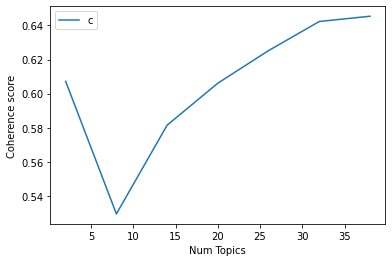

In [26]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6072
Num Topics = 8  has Coherence Value of 0.5294
Num Topics = 14  has Coherence Value of 0.5815
Num Topics = 20  has Coherence Value of 0.6061
Num Topics = 26  has Coherence Value of 0.6252
Num Topics = 32  has Coherence Value of 0.6423
Num Topics = 38  has Coherence Value of 0.6454


In [28]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.304*"system" + 0.121*"health" + 0.085*"inform" + 0.065*"sector" + '
  '0.059*"protect" + 0.048*"current" + 0.048*"revolution" + 0.017*"go_donat" + '
  '0.014*"hmi" + 0.011*"anywher"'),
 (1,
  '0.152*"check" + 0.096*"project" + 0.081*"good" + 0.070*"invest" + '
  '0.053*"ecosystem_plea" + 0.048*"cardano" + 0.045*"world" + 0.031*"part" + '
  '0.028*"ada" + 0.028*"gener"'),
 (2,
  '0.263*"patient" + 0.229*"record" + 0.078*"save" + 0.067*"life" + '
  '0.056*"defi" + 0.045*"avail" + 0.039*"live" + 0.036*"paper" + '
  '0.036*"easili" + 0.014*"comput"'),
 (3,
  '0.345*"datum" + 0.150*"serverless" + 0.118*"token" + 0.032*"base" + '
  '0.029*"link" + 0.026*"bring" + 0.022*"live" + 0.022*"beingove" + '
  '0.016*"result" + 0.016*"staff"'),
 (4,
  '0.177*"digit" + 0.068*"set" + 0.055*"transform" + 0.045*"medic" + '
  '0.045*"increa" + 0.035*"amp" + 0.035*"normal" + 0.032*"dapp" + '
  '0.032*"event" + 0.029*"smart"'),
 (5,
  '0.262*"make" + 0.103*"medp" + 0.083*"chain" + 0.074*"whatsapp" 

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data['CleanText'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.0998,"access, metaver, care, anyon, telemedicin, cos...",kingstarleo healthcar blockchain supplychain p...
1,1,19.0,0.1066,"learn, time, reliabl, support, data, eaisolut,...",healthcar blockchain supplychain procur logist...
2,2,7.0,0.0828,"blockchain, join, data, solut, earn, person, o...",nearhealth it start educ join u explor web hea...
3,3,7.0,0.0807,"blockchain, join, data, solut, earn, person, o...",nearhealth it start educ join u explor web hea...
4,4,7.0,0.0849,"blockchain, join, data, solut, earn, person, o...",nearhealth it start educ join u explor web hea...
5,5,7.0,0.0828,"blockchain, join, data, solut, earn, person, o...",nearhealth it start educ join u explor web hea...
6,6,7.0,0.0757,"blockchain, join, data, solut, earn, person, o...",it start educ join u explor web healthcar indu...
7,7,0.0,0.0500,"system, health, inform, sector, protect, curre...",vanivina healthcar blockchain ty khulood alman...
8,8,0.0,0.0500,"system, health, inform, sector, protect, curre...",vanivina healthcar blockchain ty khulood almani
9,9,0.0,0.0738,"system, health, inform, sector, protect, curre...",accord research blockchain applic healthcar al...


In [30]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1255,"system, health, inform, sector, protect, curre...",metaversecar we offer confidenti record keep s...
1,1.0,0.1797,"check, project, good, invest, ecosystem_plea, ...",theadaap liqwidfin best cardano ada project in...
2,2.0,0.1906,"patient, record, save, life, defi, avail, live...",cardian aadafin meow swap wingriderscom minswa...
3,3.0,0.1176,"datum, serverless, token, base, link, bring, l...",crypto diva everyon health deserv protect insu...
4,4.0,0.2348,"digit, set, transform, medic, increa, amp, nor...",carolint did know healthcar challeng solv bloc...


In [31]:
# Number of Documents for Each Topic
import pandas
df_topic_sents_keywords = df_topic_sents_keywords.sort_values(['Dominant_Topic'], ascending=False)
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index(ascending=False)
topic_counts = topic_counts.reset_index(level=0)
topic_counts.rename(columns = {'index' : 'Dominant_Topic_Value', 'Dominant_Topic' : 'Dominant_Topic_count'}, inplace = True)
topic_counts

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution.rename(columns = {'Dominant_Topic_count' : 'Dominant_Topic_count_Percentage'}, inplace = True)
topic_contribution. drop("Dominant_Topic_Value", axis=1, inplace=True)
topic_contribution
topic_contribution = topic_contribution.reset_index(level=0)


# Topic Number and Keywords
df_topic_sents_keywords = df_topic_sents_keywords.sort_values(['Dominant_Topic'], ascending=False).drop_duplicates(['Dominant_Topic'])
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
topic_num_keywords
topic_num_keywords = topic_num_keywords.reset_index(level=0)

topic_num_keywords['Topic_Counts'] = topic_counts['Dominant_Topic_count']
topic_num_keywords['Topic_Contribution'] = topic_contribution['Dominant_Topic_count_Percentage']
topic_num_keywords

,index,Dominant_Topic,Topic_Keywords,Topic_Counts,Topic_Contribution
0,972,19.0,"learn, time, reliabl, support, data, eaisolut,...",72,0.0343
1,136,18.0,"health, blockchain, medic, build, simbachain, ...",46,0.0219
2,511,17.0,"healthcar, worker, proof, cryptocurreci, long,...",55,0.0262
3,1636,16.0,"web, cloudcomput, tobiaskintzel, healthcar, di...",126,0.0601
4,1450,15.0,"healthcar, era, power, sever, data, cloudcompu...",55,0.0262
5,166,14.0,"blockchain, solv, medicin, seek, commun, devel...",52,0.0248
6,1485,13.0,"program, patient, platform, expand, manufactur...",131,0.0624
7,257,12.0,"nft, work, cyberattack, year, potenti, compani...",102,0.0486
8,2085,11.0,"access, metaver, care, anyon, telemedicin, cos...",69,0.0329
9,1879,10.0,"http, covid, test, rqwpieycqg, lillytoken, thi...",92,0.0439
